# Compressor de Imagens

### Inicialização de bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import fftpack
import matplotlib.image as mpimg
from collections import Counter
import pickle
import os.path

### Funções Auxiliares

In [2]:
def get_2d_dct(img):
    """ Get 2D Cosine Transform of Image
    """
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

def get_2d_idct(coefficients):
    """ Get 2D Inverse Cosine Transform of Image
    """
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)

def calcEntropy(img):
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    hist = hist.ravel()/hist.sum()
    logs = np.log2(hist+0.00001)
    entropy = -1 * (hist*logs).sum()

    return entropy

def calcEntropyList(list):

    dictionary = {}

    for i in list:
        if dictionary.get(i) == None:
            dictionary[i] = 1
        else:
            dictionary[i] = dictionary[i]+1

    for key in dictionary:
        dictionary[key] = dictionary[key]/len(aux)
    
    values = dictionary.values()

    return -sum(map(lambda x: x*np.log2(x), values))

def calcHist(list):
    
    dictionary = {}

    for i in list:
        if dictionary.get(i) == None:
            dictionary[i] = 1
        else:
            dictionary[i] = dictionary[i]+1
            
    return dictionary

### Matriz de Quantização

In [3]:
# aplicação da tabela de quantização
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# quantization matrix
QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

QM = QM.astype(float)

### Funções principais

In [4]:
def dct(img_path):
    img = cv2.imread(img_path,0)
    img = img.astype(float)
    step = 8
    size = img.shape
    
    new_size = (size[0] + 8 - (size[0]%8), size[1] + 8 - (size[1]%8))
    new_img = np.zeros(new_size)
    new_img[0:size[0], 0:size[1]] = img
    
    DCT = np.zeros(new_img.shape, dtype=np.float64)
    DC = np.zeros((new_img.shape[0]//8, new_img.shape[1]//8), dtype=np.float64)
    
    new_img = new_img-128
    
    for y in range(0,new_size[0],step):
        for x in range(0,new_size[1],step):
            dct = get_2d_dct(new_img[y:y+step, x:x+step])
            DC[y//8, x//8] = dct[0,0]
            dct = np.divide(dct, QM)
            dct = dct.round()
            DCT[y:y+step, x:x+step] = dct
    
    return img, DCT, DC, size

def idct(DCT, DC, orignal_size):
    size = DCT.shape
    step = 8
    IDCT = np.zeros(DCT.shape, dtype=np.float64)
    
    for y in range(0,size[0],step):
        for x in range(0,size[1],step):
            dct = np.multiply(DCT[y:y+step, x:x+step], QM)
            dct[0,0] = DC[y//8, x//8]
            IDCT[y:y+step, x:x+step] = get_2d_idct(dct)

    IDCT = IDCT + 128
    
    IDCT = IDCT[0:original_size[0], 0:original_size[1]]
    
    return IDCT

def zigzag(DCT):
    step = 8
    
    vector = []

    for x in range(0, DCT.shape[0], step):
        for y in range(0, DCT.shape[1], step):
            local = DCT[x:x+8, y:y+8]

            (i,j) = (0,0)

            while i < 8 and j < 8:
                vector.append(int(local[i,j]))
                # subida
                if (i+j)%2 == 0:
                    # borda esquerda da matriz
                    if j == 7:
                        i = i+1
                        continue
                    # borda superior da matriz
                    if i == 0:
                        j = j+1
                        continue
                    i = i-1
                    j = j+1

                #descida
                else:
                    # borda inferior da matriz
                    if i == 7:
                        j = j+1
                        continue
                    # borda direita da matriz
                    if j == 0:
                        i = i+1
                        continue
                    i = i+1
                    j = j-1
    
    return vector, DCT.shape

def DeZigZag(vector, shape):
    
    step = 8
    reconstruct = np.zeros(shape, dtype=np.float64)
    index = 0

    for x in range(0, shape[0], step):
        for y in range(0, shape[1], step):

            (i,j) = (0,0)

            while i < 8 and j < 8:
                reconstruct[x+i,y+j] = vector[index]
                index = index+1
                # subida
                if (i+j)%2 == 0:
                    # borda esquerda da matriz
                    if j == 7:
                        i = i+1
                        continue
                    # borda superior da matriz
                    if i == 0:
                        j = j+1
                        continue
                    i = i-1
                    j = j+1

                #descida
                else:
                    # borda inferior da matriz
                    if i == 7:
                        j = j+1
                        continue
                    # borda direita da matriz
                    if j == 0:
                        i = i+1
                        continue
                    i = i+1
                    j = j-1

    return reconstruct

def lossless_predictive(vector):
    aux = [vector[0]]
    
    for i in range(1,len(vector)):
        aux.append(vector[i]-vector[i-1])
        
    return aux

def undo_lossless_predictive(vector):
    reconstruct = [vector[0]]
    
    for i in range(1,len(vector)):
        reconstruct.append(reconstruct[-1]+vector[i])
        
    return reconstruct

def huffman(DCT, DC):
    return None

def decode(coded_file):
    return DCT, DC

In [17]:
#https://www.javatpoint.com/huffman-coding-using-python#:~:text=Huffman%20coding%20is%20a%20lossless,utilized%20for%20lossless%20data%20compression.

# Node of a Huffman Tree  
class Nodes:  
    def __init__(self, probability, symbol, left = None, right = None):  
        # probability of the symbol  
        self.probability = probability  
  
        # the symbol  
        self.symbol = symbol  
  
        # the left node  
        self.left = left  
  
        # the right node  
        self.right = right  
  
        # the tree direction (0 or 1)  
        self.code = ''  
        
""" A supporting function in order to calculate the probabilities of symbols in specified data """  
def CalculateProbability(the_data):  
    the_symbols = dict()  
    for item in the_data:  
        if the_symbols.get(item) == None:  
            the_symbols[item] = 1  
        else:   
            the_symbols[item] += 1       
    return the_symbols  
  
""" A supporting function in order to print the codes of symbols by travelling a Huffman Tree """  
# dictionary = dict()
  
def CalculateCodes(node,  dictionary, value = ''): 
    # a huffman code for current node  
    newValue = value + str(node.code)  
  
    if(node.left):  
        CalculateCodes(node.left, dictionary, newValue)  
    if(node.right):  
        CalculateCodes(node.right, dictionary, newValue)  
  
    if(not node.left and not node.right):  
        dictionary[node.symbol] = newValue  
           
    return dictionary

def HuffmanEncoding(the_data):  
    symbolWithProbs = CalculateProbability(the_data)
    the_symbols = symbolWithProbs.keys()
    the_probabilities = symbolWithProbs.values()
    
    the_nodes = []
      
    # converting symbols and probabilities into huffman tree nodes  
    for symbol in the_symbols:  
        the_nodes.append(Nodes(symbolWithProbs.get(symbol), symbol))

      
    while len(the_nodes) > 1:  
        # sorting all the nodes in ascending order based on their probability  
        the_nodes = sorted(the_nodes, key = lambda x: x.probability)

        # picking two smallest nodes  
        right = the_nodes[0]
        left = the_nodes[1]
      
        left.code = 0 
        right.code = 1
      
        # combining the 2 smallest nodes to create new node  
        newNode = Nodes(left.probability + right.probability, left.symbol + right.symbol, left, right)
      
        the_nodes.remove(left)
        the_nodes.remove(right)
        the_nodes.append(newNode)
        
    the_codes = dict()
              
    huffmanEncoding = CalculateCodes(the_nodes[0], the_codes)
    return huffmanEncoding

In [18]:
encoding = HuffmanEncoding(predictive)
print(encoding)

new_dict = {}

for key in encoding.keys():
    binary_value = encoding[key]
    new_dict[key] = (len(binary_value), int(binary_value, 2))
    
print(new_dict)

decode_dict = {}

get_bin = lambda x, n: format(x, 'b').zfill(n)

for key in new_dict.keys():
    int_representation = new_dict[key]
    decode_dict[key] = get_bin(int_representation[1], int_representation[0])
    
print(decode_dict)

{0: '0', -1: '1000', 30: '100100000', -37: '100100001', 19: '10010001', 4: '10010010', 8: '1001001100000', -12: '1001001100001', 9: '1001001100010', 11: '10010011000110', 12: '10010011000111', 7: '10010011001', -8: '10010011010', -9: '10010011011', 34: '100100111', 25: '10010100', -15: '100101010', -32: '100101011', -25: '10010110', 21: '10010111', -19: '10011000', 26: '10011001', 20: '10011010', -21: '10011011', -3: '1001110', -20: '10011110', 23: '10011111', -14: '101000000', 15: '101000001', -23: '10100001', 18: '10100010', -6: '101000110', -13: '101000111', 22: '10100100', -38: '10100101', 38: '10100110', 14: '101001110', -7: '1010011110', -10: '10100111110', -11: '10100111111', -22: '10101000', -16: '10101001', 64: '10101010', -64: '10101011', -17: '10101100', -26: '10101101', -18: '10101110', 13: '101011110', 6: '101011111', 27: '10110000', 5: '10110001', -30: '10110010', -31: '10110011', 16: '10110100', 17: '10110101', -33: '10110110', -27: '10110111', -2: '10111', -29: '1100000

In [27]:
def encodeData(data, encoding):
    encoded_data = []
    
    for value in data:
        encoded_data.append(encoding[value])
        
    encoded_string = ''.join(encoded_data)
    
    size = len(encoded_string)
    
    for i in range(8-(size%8)):
        encoded_string += '0'
    
    return encoded_string

encoded_string = encodeData(predictive, encoding)

# print(len(encoded_string))

aux = encoded_string

for i in range(0, 8-(len(encoded_string)%8)):
    aux += '0'
    
new_vals = []
    
for i in range(0, len(aux), 8):
    new_vals.append(int(aux[i:i+8], 2))

# print(new_vals)

new_codes = dict()

encoding_2 = HuffmanEncoding(new_vals)

228225
228232


### Implementação

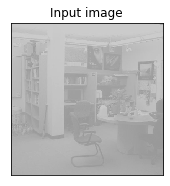

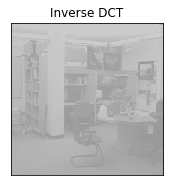

RMSE: 1.916
PSNR: 42.484


In [5]:
img, DCT, DC, original_size = dct('unequal.png')
vector, shape = zigzag(DCT)
predictive = lossless_predictive(vector)
after_prediction = undo_lossless_predictive(predictive)
DCT = DeZigZag(after_prediction, shape)
IDCT = idct(DCT, DC, original_size)
        
plt.subplot(121),plt.imshow(img, cmap = 'gray', clim=(0, 255))
plt.title('Input image'), plt.xticks([]), plt.yticks([])
plt.show()

plt.subplot(121),plt.imshow(IDCT, cmap = 'gray', clim=(0, 255))
plt.title('Inverse DCT'), plt.xticks([]), plt.yticks([])
plt.show()

print ("RMSE: %5.3f" % rmse(img, IDCT))
print ("PSNR: %5.3f" % psnr(img, IDCT))